# Sobre o conjunto de dados

## cse-cic-ids2018

## Informações básicas
Este conjunto de dados foi originalmente criado pela Universidade de New Brunswick para analisar dados DDoS. Este conjunto de dados foi totalmente adquirido a partir de 2018 e não será atualizado no futuro, no entanto, novas versões do conjunto de dados estarão disponíveis no link acima. O próprio conjunto de dados foi 
baseado em logs dos servidores da universidade, que encontraram vários ataques DoS ao longo do período disponível publicamente. 
Ao escrever notebooks de aprendizado de máquina para esses dados, observe que a coluna Rótulo é sem dúvida a parte mais 
importante dos dados, pois determina se os pacotes enviados são maliciosos ou não.

## Estrutura do arquivo
Os dados são divididos em vários arquivos com base na data. Cada arquivo individual é desbalanceado e cabe ao criador do 
notebook dividir o conjunto de dados em um formato balanceado para previsões de maior qualidade.

## Estrutura da coluna
No total, existem oitenta colunas dentro deste conjunto de dados, cada uma das quais corresponde a uma entrada no sistema de 
registro de IDS que a Universidade de New Brunswick possui. Como o sistema classifica o tráfego como para frente e para trás, há 
colunas para ambos. As colunas mais importantes nesse conjunto de dados estão listadas abaixo.

#### ->Dst Port (porta de destino)

#### ->Protocolo

#### ->Duração do fluxo (Flow Duration)

#### ->Tot Fwd Pkts (Total de pacotes de encaminhamento)

#### ->Tot Bwd Pkts (Total de pacotes para trás)

#### ->Rótulo (Label)

## Fontes de dados
Para obter mais informações sobre esse conjunto de dados, recomendo olhar aqui , que leva ao site oficial da Universidade de New
Brunswick. Para acessar mais dados, incluindo os arquivos de log brutos (que totalizam cerca de 450 GB), consulte a página AWS 
Open Data . Você precisa fazer download da AWS CLI para o sistema operacional de sua escolha antes de fazer download dos dados 
brutos. Para baixar os dados, digite aws s3 sync s3://cse-cic-ids2018/ [INSERT DOWNLOAD DIRECTORY HERE] --no-sign-request. Você 
    não precisa de uma conta da AWS para copiar dados para seu próprio dispositivo, daí o --no-sign-requestsinalizador.

## Pontas
Devido à grande quantidade de dados englobados apenas nos arquivos CSV, convém pré-classificar os dados no Python, o que 
acelerará o processamento real de dados no PyTorch ou no TensorFlow.

In [1]:
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree  import DecisionTreeClassifier
from sklearn import tree
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('02-14-2018.csv')
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [3]:
df_pr = df.loc[:,['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Label']]
df_pr

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
0,0,0,112641719,3,0,Benign
1,0,0,112641466,3,0,Benign
2,0,0,112638623,3,0,Benign
3,22,6,6453966,15,10,Benign
4,22,6,8804066,14,11,Benign
...,...,...,...,...,...,...
1048570,80,6,10156986,5,5,Benign
1048571,80,6,117,2,0,Benign
1048572,80,6,5095331,3,1,Benign
1048573,80,6,5235511,3,1,Benign


In [4]:
df_pr['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [5]:
df_pr.isnull().sum()

Dst Port         0
Protocol         0
Flow Duration    0
Tot Fwd Pkts     0
Tot Bwd Pkts     0
Label            0
dtype: int64

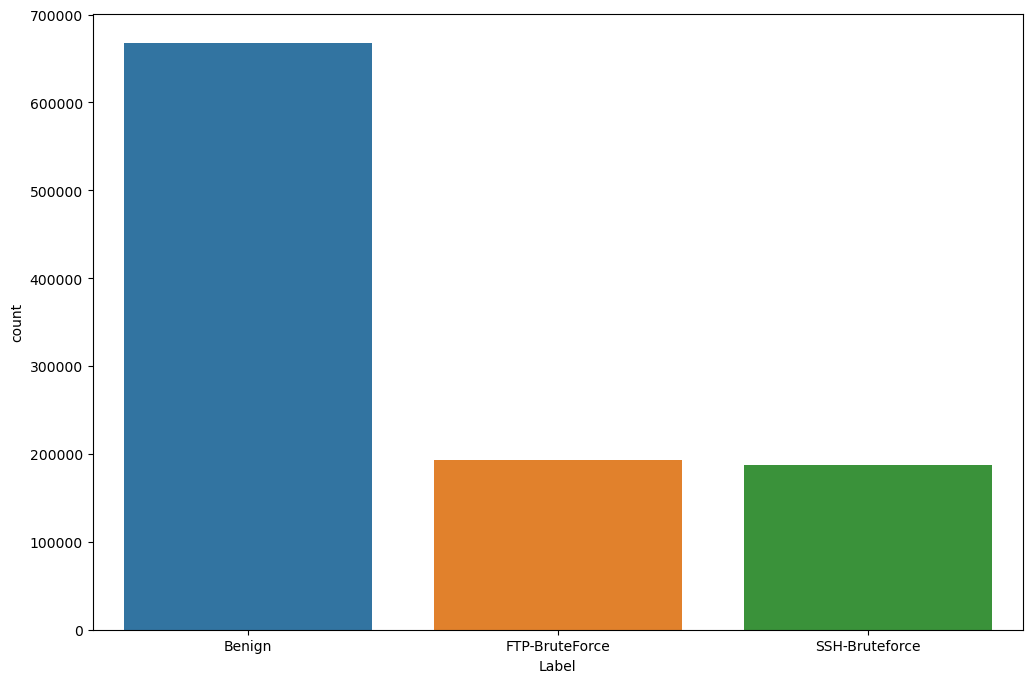

In [7]:
ax = sns.countplot(x="Label",data=df_pr)
ax.figure.set_size_inches(12, 8)

In [8]:
label_encoder = LabelEncoder()
labels_df = label_encoder.fit_transform(df_pr.Label)
labels_df

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
df_pr['Label']=labels_df
df_pr

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
0,0,0,112641719,3,0,0
1,0,0,112641466,3,0,0
2,0,0,112638623,3,0,0
3,22,6,6453966,15,10,0
4,22,6,8804066,14,11,0
...,...,...,...,...,...,...
1048570,80,6,10156986,5,5,0
1048571,80,6,117,2,0,0
1048572,80,6,5095331,3,1,0
1048573,80,6,5235511,3,1,0


In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for treino, teste in split.split(df_pr, df_pr["Label"]):
    strat_treino = df_pr.loc[treino]
    strat_teste = df_pr.loc[teste]

In [12]:
strat_treino

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
135924,21,6,5,1,1,1
571728,53,17,492,1,1,0
1026967,3389,6,3467731,10,7,0
14149,21,6,2,1,1,1
418098,53,17,581,1,1,0
...,...,...,...,...,...,...
179322,21,6,2,1,1,1
593301,53,17,1307,1,1,0
924995,80,6,5313112,2,1,0
995927,3389,6,2423668,8,7,0


In [13]:
strat_teste

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,Label
571357,0,0,80895,2,0,0
442302,53,17,644,1,1,0
639345,80,6,55139789,2,0,0
924873,50212,6,287,2,1,0
129093,21,6,1,1,1,1
...,...,...,...,...,...,...
351203,22,6,376396,22,22,2
123206,21,6,2,1,1,1
306860,22,6,374766,21,22,2
608473,3389,6,2398026,10,7,0


In [14]:
Xtreino = strat_treino.iloc[:,:-1]
Ytreino = strat_treino['Label']

Xteste = strat_teste.iloc[:,:-1]
Yteste = strat_teste['Label']

In [15]:
Xtreino

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts
135924,21,6,5,1,1
571728,53,17,492,1,1
1026967,3389,6,3467731,10,7
14149,21,6,2,1,1
418098,53,17,581,1,1
...,...,...,...,...,...
179322,21,6,2,1,1
593301,53,17,1307,1,1
924995,80,6,5313112,2,1
995927,3389,6,2423668,8,7


In [16]:
Ytreino

135924     1
571728     0
1026967    0
14149      1
418098     0
          ..
179322     1
593301     0
924995     0
995927     0
933846     0
Name: Label, Length: 838860, dtype: int32

In [17]:
Xteste

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts
571357,0,0,80895,2,0
442302,53,17,644,1,1
639345,80,6,55139789,2,0
924873,50212,6,287,2,1
129093,21,6,1,1,1
...,...,...,...,...,...
351203,22,6,376396,22,22
123206,21,6,2,1,1
306860,22,6,374766,21,22
608473,3389,6,2398026,10,7


In [18]:
Yteste

571357    0
442302    0
639345    0
924873    0
129093    1
         ..
351203    2
123206    1
306860    2
608473    0
530638    0
Name: Label, Length: 209715, dtype: int32

### KNN 

In [20]:
KNN= KNeighborsClassifier(n_neighbors=6) 
KNN.fit(Xtreino, Ytreino)

KNeighborsClassifier(n_neighbors=6)

In [21]:
KNN.score(Xtreino, Ytreino), KNN.score(Xteste, Yteste)

C:\Users\resid\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\resid\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



(0.9977970102281668, 0.9971485110745536)

### Random Forest Classifier

In [22]:
RF = RandomForestClassifier()
RF.fit(Xtreino, Ytreino)
   
RF.score(Xtreino, Ytreino), RF.score(Xteste, Yteste)

(0.999971389743223, 0.999952316238705)

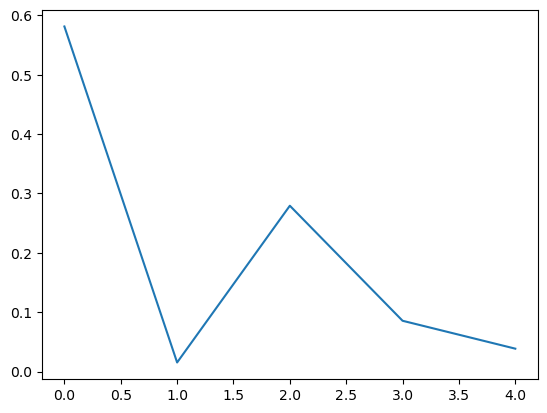

In [23]:
plt.plot(RF.feature_importances_)

In [24]:
RF.feature_importances_

array([0.58127496, 0.01528932, 0.27933531, 0.08554561, 0.0385548 ])

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
y_pred = RF.predict(Xteste)

In [27]:
print(classification_report(Yteste, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133525
           1       1.00      1.00      1.00     38672
           2       1.00      1.00      1.00     37518

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



In [28]:
print(confusion_matrix(Yteste, y_pred))

[[133525      0      0]
 [     0  38672      0]
 [     0     10  37508]]


In [29]:
feature_names = df_pr.columns[:-1]
feature_names

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts'],
      dtype='object')

In [30]:
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

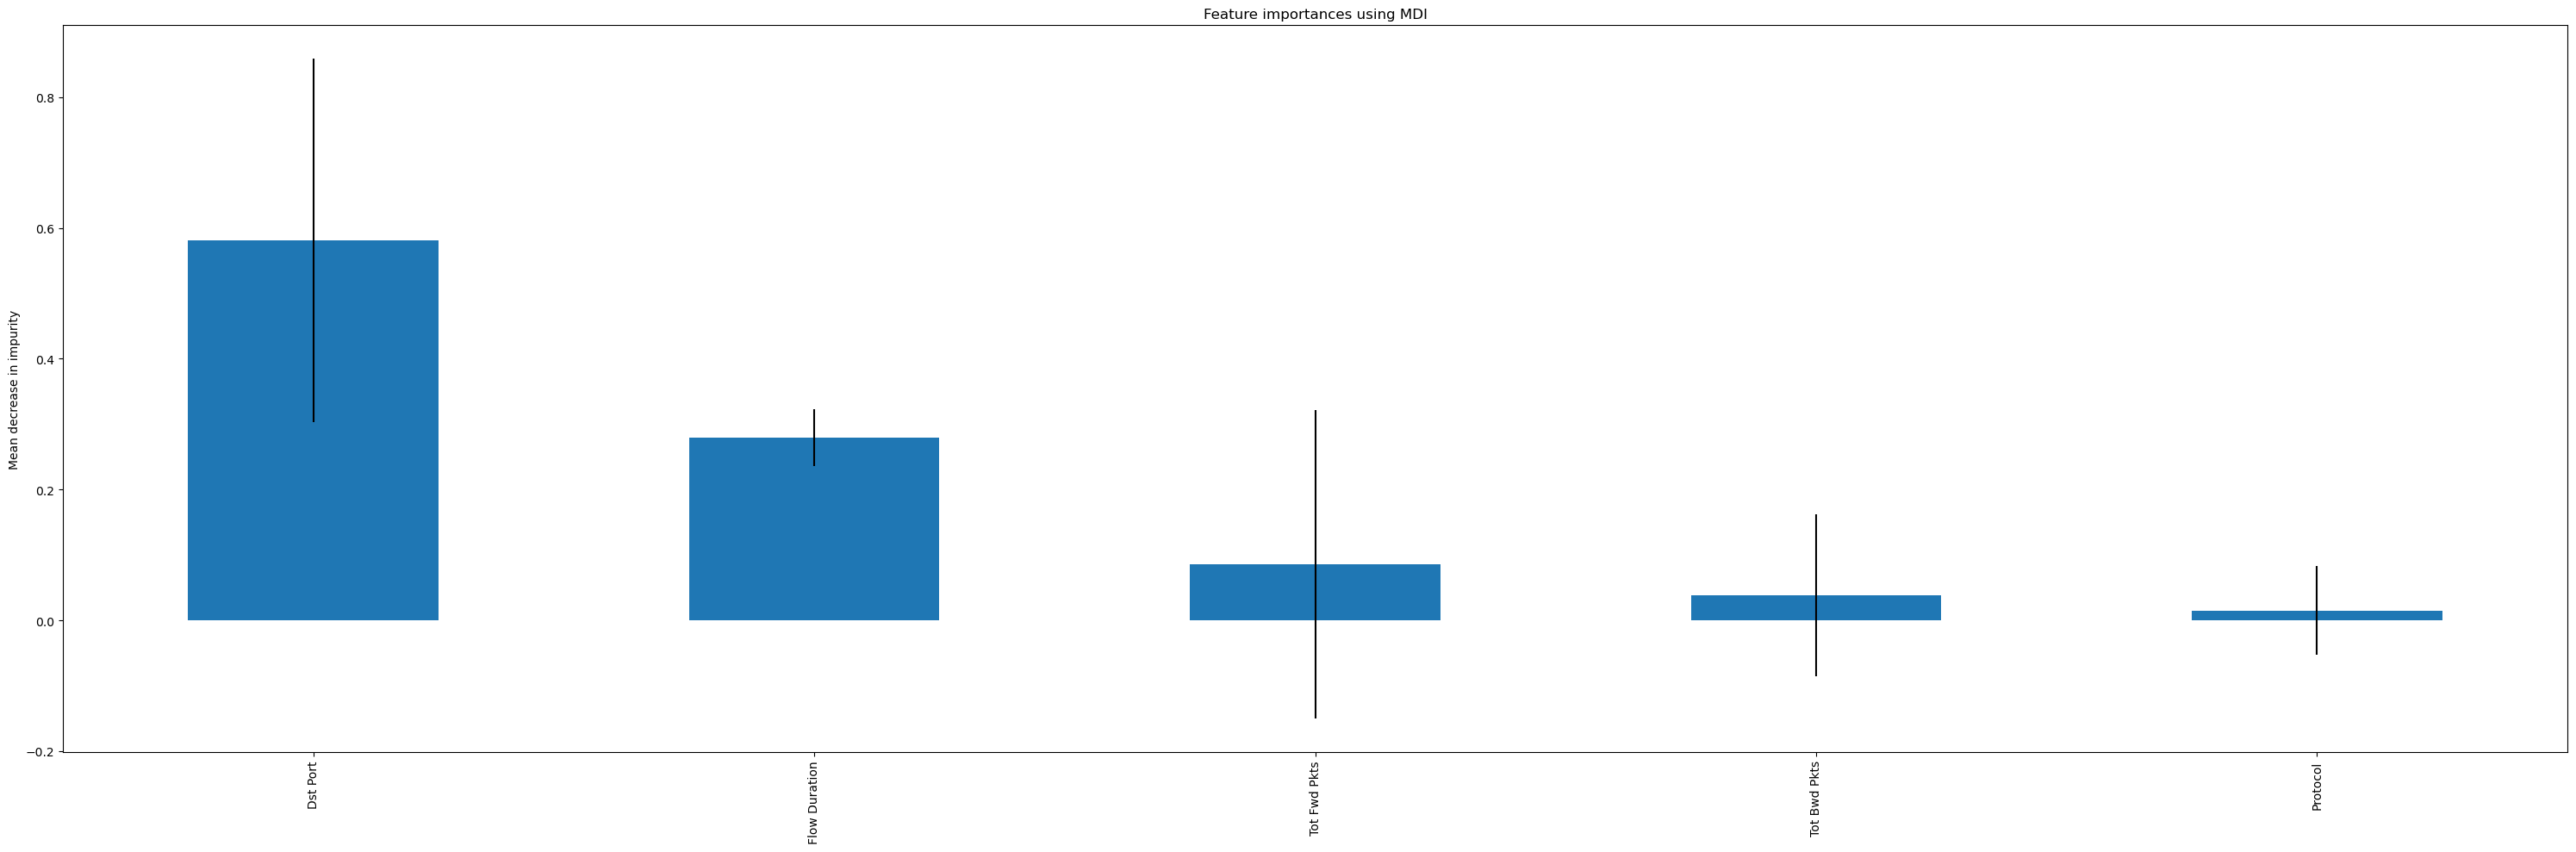

In [31]:
forest_importances = pd.Series(RF.feature_importances_, index=feature_names)

fig, ax = plt.subplots(figsize=(30, 10))
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [32]:
forest_importances.sort_values(ascending=False)

Dst Port         0.581275
Flow Duration    0.279335
Tot Fwd Pkts     0.085546
Tot Bwd Pkts     0.038555
Protocol         0.015289
dtype: float64

### SVM Classifier 

In [33]:
Linear_SVC = svm.LinearSVC(C=1)
Linear_SVC.fit(Xtreino, Ytreino)

C:\Users\resid\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=1)

In [34]:
Linear_SVC.score(Xtreino, Ytreino), Linear_SVC.score(Xteste, Yteste)

(0.5028967884986768, 0.5028538731135112)

### Decision Tree Classifier

In [35]:
DT =DecisionTreeClassifier(max_features=5, max_depth=4)
DT.fit(Xtreino, Ytreino)

DecisionTreeClassifier(max_depth=4, max_features=5)

In [36]:
DT.score(Xtreino, Ytreino), DT.score(Xteste, Yteste)

(0.9999558925208021, 0.9999332427341868)

[Text(0.6666666666666666, 0.9, 'X[0] <= 22.5\ngini = 0.529\nsamples = 838860\nvalue = [534101, 154688, 150071]'),
 Text(0.5555555555555556, 0.7, 'X[0] <= 21.5\ngini = 0.529\nsamples = 314496\nvalue = [9737, 154688, 150071]'),
 Text(0.3333333333333333, 0.5, 'X[2] <= 54.0\ngini = 0.109\nsamples = 164185\nvalue = [9477, 154688, 20]'),
 Text(0.2222222222222222, 0.3, 'X[0] <= 20.5\ngini = 0.0\nsamples = 154716\nvalue = [8, 154688, 20]'),
 Text(0.1111111111111111, 0.1, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 154710\nvalue = [2, 154688, 20]'),
 Text(0.4444444444444444, 0.3, 'gini = 0.0\nsamples = 9469\nvalue = [9469, 0, 0]'),
 Text(0.7777777777777778, 0.5, 'X[2] <= 669710.5\ngini = 0.003\nsamples = 150311\nvalue = [260, 0, 150051]'),
 Text(0.6666666666666666, 0.3, 'X[4] <= 0.5\ngini = 0.0\nsamples = 150066\nvalue = [15, 0, 150051]'),
 Text(0.5555555555555556, 0.1, 'gini = 0.32\nsamples = 5\nvalue = [1, 0, 4]'),
 Text(0.7777777777777

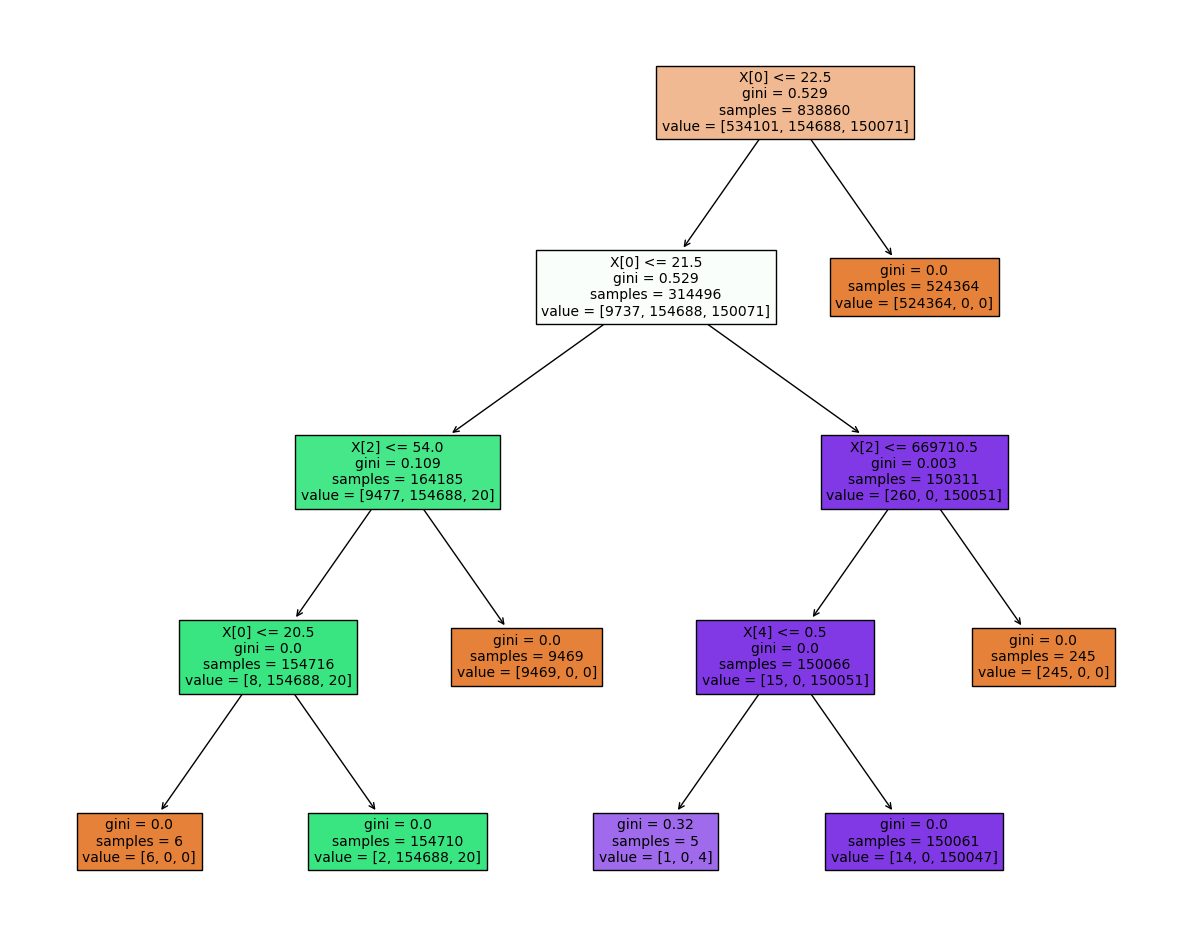

In [37]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(DT, filled=True)